# Problem : Clustering the listings based on latitude, longitude and overall review scores
- We cluster the listings based on latitude, longitude and overall review scores to help the travellers to choose the listings based on the location and also the scores
- Task:Clustering the listings based on latitude, longitude and overall review scores
- Performance measure:Use some metrics provided in sklearn which can measure the performance of K-means learning without ground truth
- Experience:Latitude, longitude and review scores in listings dataset



# Import all the libraries needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import folium
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import sklearn.preprocessing
from sklearn.pipeline import Pipeline

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
sns.color_palette("tab10")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Preprocessing of listings.csv
- Convert price column to numerical
- Remove outliers of price column and plot the boxplot
- Preprocess all the review scores columns to find the overall score which perform K-means better than just passing all the review columns

[Text(0.5, 1.0, 'Box Plot of Price ($)')]

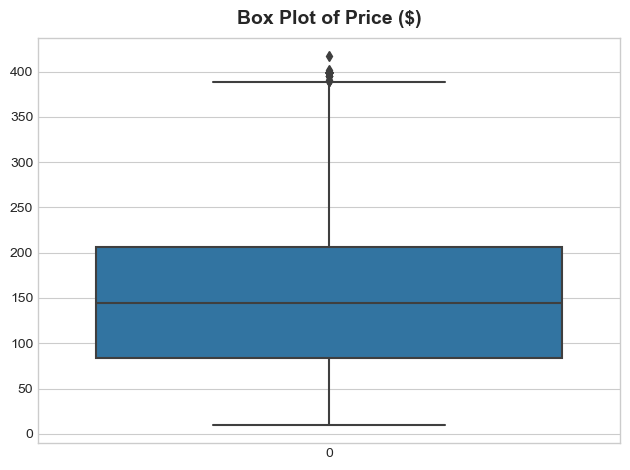

In [2]:
df = pd.read_csv("./listings.csv")
price_cols_index = df.columns[df.columns.str.contains('price') == True]
for variable in price_cols_index:
    df[variable] = df[variable].map(lambda x: x.replace("$",'').replace(",",''),
                                                na_action = 'ignore')
    df[variable] = df[variable].astype(float)
# Remove outliers
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df["price"] < (Q1 - 1.5 * IQR)) |(df["price"] > (Q3 + 1.5 * IQR)))]
Y = df["price"]
sns.boxplot(data=Y).set(title="Box Plot of Price ($)")

In [3]:
df["review_scores_rating"].fillna(0, inplace=True)
df["review_scores_value"].fillna(0, inplace=True)
df["review_scores_accuracy"].fillna(0, inplace=True)
df["review_scores_cleanliness"].fillna(0, inplace=True)
df["review_scores_checkin"].fillna(0, inplace=True)
df["review_scores_communication"].fillna(0, inplace=True)
df["review_scores_location"].fillna(0, inplace=True)

df["overall_review_scores"] = (df["review_scores_rating"] / 10 + df["review_scores_value"] + df["review_scores_accuracy"] +
                              df["review_scores_cleanliness"] + df["review_scores_checkin"] + df["review_scores_communication"]+
                              df["review_scores_location"]) / 7

# X = df[["latitude", "longitude", "review_scores_rating", "review_scores_value", "review_scores_accuracy",
#         "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location"]]
X = df[["latitude", "longitude", "overall_review_scores"]]

# K-means algorithm
- Use elbow method to decide optimum K
- Use some metrics provided in sklearn which can measure the performance of K-means learning without ground truth to choose the best K
- Plot the relationship between the metrics and the K

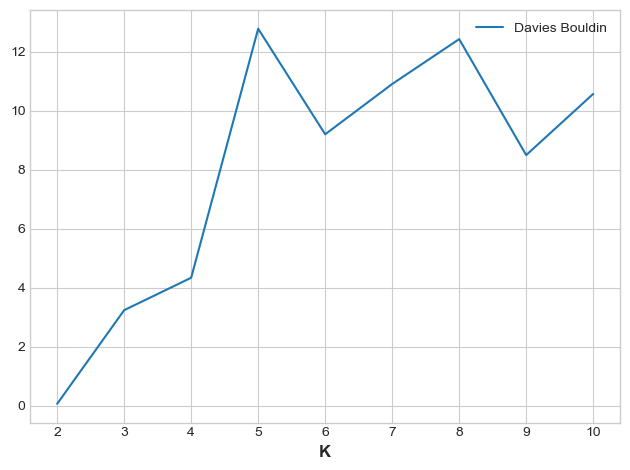

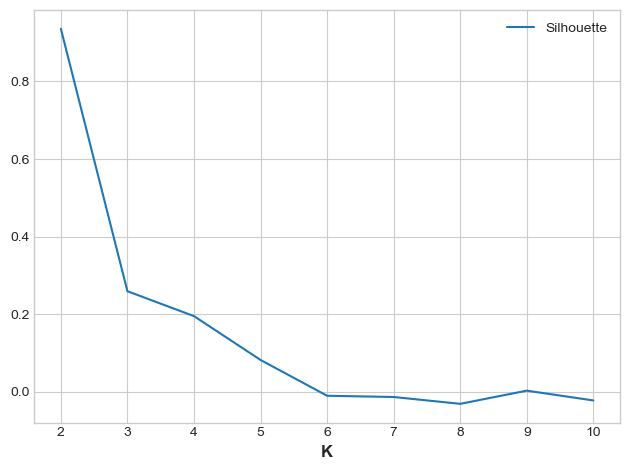

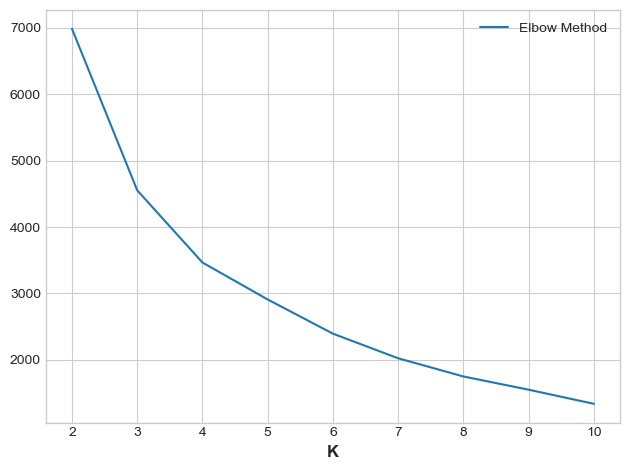

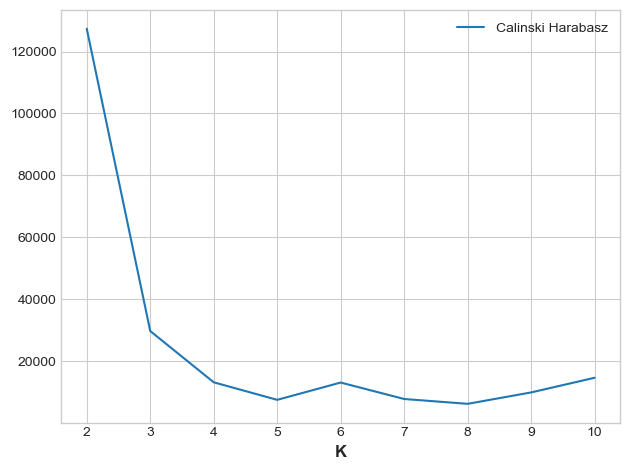

[0.0639005982507127, 3.2395579723533943, 4.338367563815531, 12.781171103635348, 9.202569739855779, 10.907707729588806, 12.429703501761725, 8.498093798061731, 10.571797059229196] [0.9360044047985538, 0.25909440000913964, 0.19489220478683628, 0.08182479619700879, -0.010474745464865046, -0.013695855461861731, -0.03129526515240415, 0.0026388289441679792, -0.022589498889153643] [127352.67834994408, 29708.458455446857, 13145.083037814815, 7476.4975586542205, 13064.77230019983, 7751.588288983259, 6189.989956001389, 9873.050709197121, 14609.614888477961] [6984.36179399955, 4552.44291815891, 3465.5283423453775, 2908.9283922284035, 2394.2818787875135, 2023.641598580305, 1750.0407025881557, 1550.8626440813316, 1338.0798688692403]


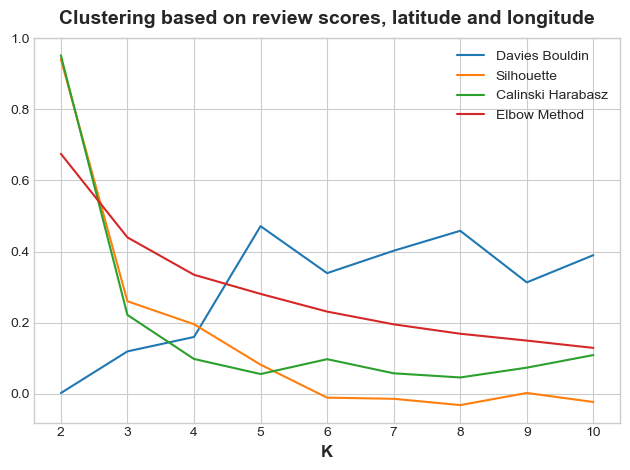

In [4]:
db_score, s_score, ch_score = [], [], []
inertia = []
for n in range(2, 11):
    n_cluster = n
    pipe = Pipeline([
            ("scaling", sklearn.preprocessing.StandardScaler()),
            ("kmeans", KMeans(n_clusters=n))
        ])
    result = pipe.fit(X)
    labels = result["kmeans"].labels_
    db_score.append(davies_bouldin_score(X, labels)) # Low implies well
    s_score.append(silhouette_score(X, labels)) # High implies well
    ch_score.append(calinski_harabasz_score(X, labels)) # High implies well
    inertia.append(result["kmeans"].inertia_) # Low implies well
    
plt.figure()
plt.plot([n for n in range(2, 11)], db_score, label="Davies Bouldin")
plt.xlabel("K")
plt.legend()
plt.show()

plt.figure()
plt.plot([n for n in range(2, 11)], s_score, label="Silhouette")
plt.xlabel("K")
plt.legend()
plt.show()

plt.figure()
plt.plot([n for n in range(2, 11)], inertia, label="Elbow Method")
plt.xlabel("K")
plt.legend()
plt.show()

plt.figure()
plt.plot([n for n in range(2, 11)], ch_score, label="Calinski Harabasz")
plt.xlabel("K")
plt.legend()
plt.show()

print(db_score, s_score, ch_score, inertia)
db_score = sklearn.preprocessing.normalize([db_score])    
s_score = sklearn.preprocessing.normalize([s_score])
ch_score = sklearn.preprocessing.normalize([ch_score])
inertia = sklearn.preprocessing.normalize([inertia])

plt.figure()
plt.title("Clustering based on review scores, latitude and longitude")
plt.plot([n for n in range(2, 11)], db_score[0, :], label="Davies Bouldin")
plt.plot([n for n in range(2, 11)], s_score[0, :], label="Silhouette")
plt.plot([n for n in range(2, 11)], ch_score[0, :], label="Calinski Harabasz")
plt.plot([n for n in range(2, 11)], inertia[0, :], label="Elbow Method")
plt.xlabel("K")
plt.legend()
plt.show()





# Perform the K-Means using the optimal K
- Although from the result above, the optimal K should be 2, but since 2 clusters is too less so we decide to choose the second optimal K, 3

In [5]:
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster).fit(X)
labels = kmeans.labels_
X["cluster"] = labels
X["cluster"] = X["cluster"].astype("category")
X.sample(10)

/var/folders/jd/1jzp59615_ng5jq0zqr1hkkr0000gn/T/ipykernel_1064/720819086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cluster"] = labels
/var/folders/jd/1jzp59615_ng5jq0zqr1hkkr0000gn/T/ipykernel_1064/720819086.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cluster"] = X["cluster"].astype("category")


latitude  longitude  overall_review_scores cluster
3038  42.349506 -71.047613               9.371429       2
857   42.339793 -71.082264               0.000000       1
1947  42.359369 -71.071162              10.000000       2
1199  42.345028 -71.076663               8.714286       0
1268  42.348808 -71.088977               9.942857       2
3228  42.335041 -71.048583               0.000000       1
3343  42.349988 -71.144202               9.657143       2
1632  42.363827 -71.029303               9.771429       2
1426  42.347844 -71.085609               9.657143       2
3349  42.346452 -71.134896               9.585714       2

## Concantenate the clustered data with the price and calculate the mean price, mean score for each cluster

In [6]:
Z = pd.concat([X, Y], axis=1)
mean_price = Z.groupby("cluster")["price"].mean().round(2)
mean_review_score = Z.groupby("cluster")["overall_review_scores"].mean().round(2)

## Visualize number of listings in each cluster

Text(0, 0.5, 'Mean Overall Review Scores')

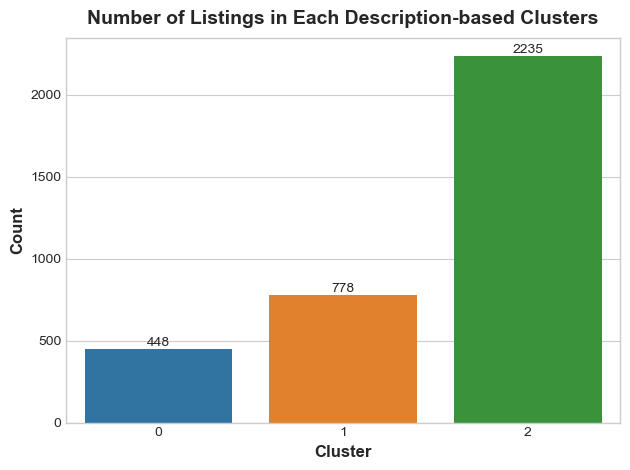

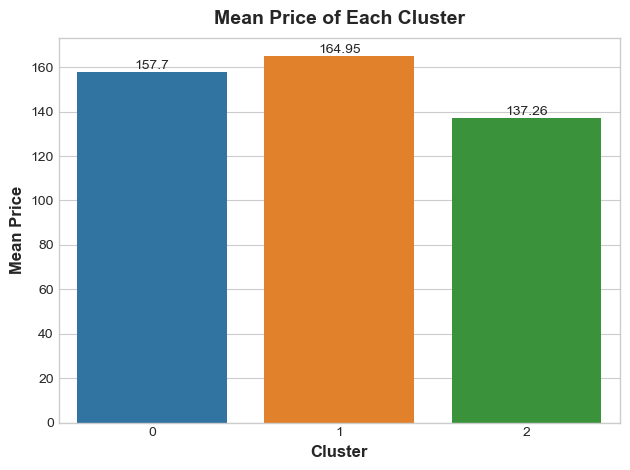

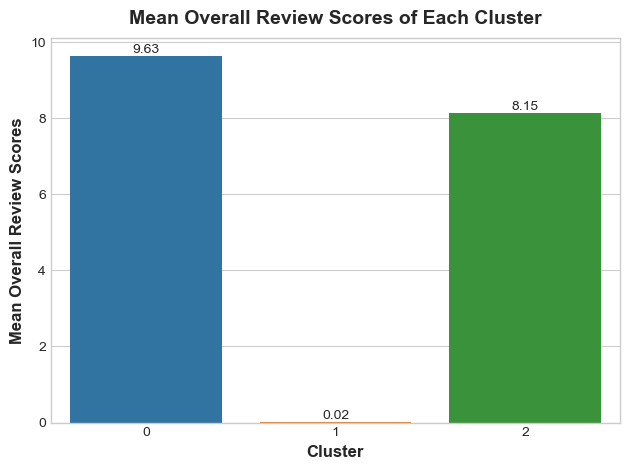

In [7]:
ClusterCount = X['cluster'].value_counts().sort_index()
ClusterCount = pd.DataFrame(ClusterCount)
ClusterCount.columns=['NumListings']
bar = sns.barplot(x=X['cluster'].value_counts().index,y=X['cluster'].value_counts())
bar.bar_label(bar.containers[0])
plt.title('Number of Listings in Each Description-based Clusters')
plt.xlabel("Cluster")
plt.ylabel("Count")

plt.figure()
bar_price = sns.barplot(x=X["cluster"].value_counts().index, y=mean_price)
bar_price.bar_label(bar_price.containers[0])
plt.title("Mean Price of Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Price")

plt.figure()
bar_review_score = sns.barplot(x=X["cluster"].value_counts().index, y=mean_review_score)
bar_review_score.bar_label(bar_review_score.containers[0])
plt.title("Mean Overall Review Scores of Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Overall Review Scores")

Number of Listings in Each Description-based Cluster:

- Cluster 0 has 448 listings.
- Cluster 1 has 778 listings.
- Cluster 2 has the most listings with 2235.

This distribution indicates that Cluster 2 is the most common, suggesting it may contain the most typical types of listings or perhaps a broad range of properties.

Mean Price of Each Cluster:

- Cluster 0 has an average price of around 157.70.
- Cluster 1 has a slightly higher average price of approximately 164.95.
- Cluster 2 has the lowest average price at about 137.26.

The mean price differences across clusters can reflect variations in property types, locations, and amenities offered. Cluster 1's higher average price could be associated with premium properties or sought-after locations.

Mean Overall Review Scores of Each Cluster:

- Cluster 0 shows a high mean review score of 9.63, indicating high guest satisfaction.
- Cluster 1 has a significantly lower mean review score, close to 0, which may suggest a lack of reviews or generally lower guest satisfaction.
- Cluster 2 has a mean review score of 8.15, which is quite high but not as high as Cluster 0.

The review scores suggest that while Cluster 0 has fewer listings than Cluster 2, its listings are better received by guests. Cluster 1, despite having a higher mean price than Cluster 2, has an anomalously low review score average, which could imply data issues or a specific aspect that markedly reduces guest satisfaction.

## Plot the points and show the mean price of each clustering

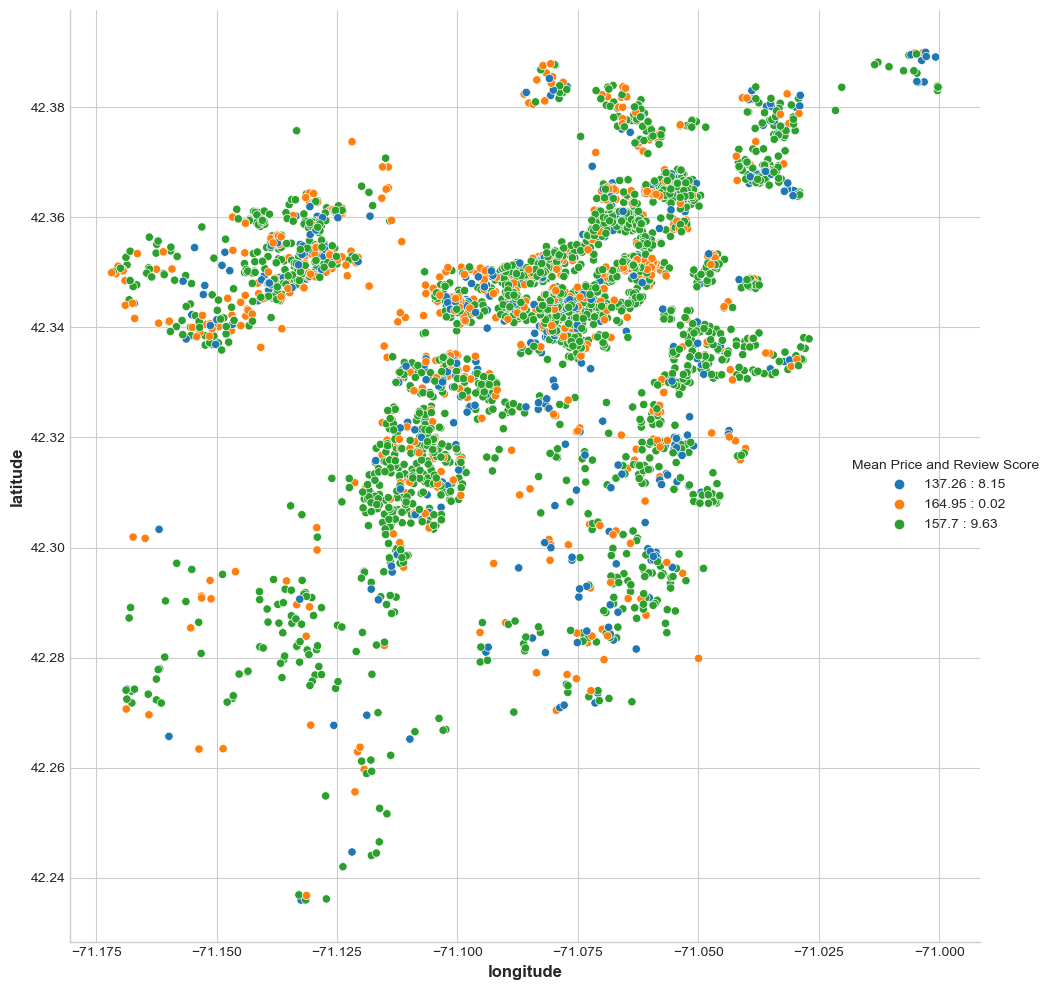

In [8]:
s = sns.relplot(
    x="longitude", y="latitude", hue="cluster", data=X, height=10
)
new_title = 'Mean Price and Review Score'
s._legend.set_title(new_title)
for t, p, s in zip(s._legend.texts, mean_price, mean_review_score):
    t.set_text(f"{p} : {s}")

The scatter plot you provided depicts the geographical distribution of Airbnb listings, color-coded by cluster, with a legend that shows the mean price and review score for each cluster:

- Cluster 0 (Green dots): Has a mean price of 157.7 and a high mean review score of 9.63, indicating that listings in this cluster are priced moderately and have high guest satisfaction.

- Cluster 1 (Orange dots): Shows a mean price of 164.95 with a very low mean review score of 0.02. This could suggest a data issue (such as missing reviews) or an aspect of the listings that guests are extremely dissatisfied with.

- Cluster 2 (Blue dots): Has a lower mean price of 137.26 and a mean review score of 8.15, which is quite good, suggesting these listings offer value for money with satisfactory guest experiences.

From the visualization:

- Listings are dispersed across a specific geographic area, with no single cluster dominating a particular region, indicating a mixed distribution of different types of listings.
- The variation in mean review scores, especially the anomalous score for Cluster 1, might require further investigation to understand the underlying reasons for such low satisfaction relative to price.
- The clusters can inform property owners and platform hosts about pricing strategies and potential areas for service improvement based on guest feedback.

This map is a valuable tool for visualizing and analyzing spatial distribution in relation to price and customer satisfaction, which can assist stakeholders in making informed decisions about property management and market positioning.

## Plot the listings on map
- Analyze possible geography factor which affects the price based on the map shown

In [9]:
colors = {0 : 'blue', 1 : 'orange', 2 : "green", 3 : "red", 
          4 : "purple",
          5:"brown", 6:"pink", 7:"grey", 8:"gold", 9:"light blue"
         }
la_mean = X["latitude"].mean()
lo_mean = X["longitude"].mean()

map_osm = folium.Map(location=[la_mean, lo_mean], zoom_start=16)

X.apply(lambda row:folium.CircleMarker(
    location=[row["latitude"], row["longitude"]], 
    radius=6, fill_color=colors[row["cluster"]],  color=colors[row["cluster"]],
    fill=True, fill_opcaity=1.0, opacity=1,
    popup=folium.Popup(f"Cluster {row['cluster']}<br>Mean Price : {mean_price[row['cluster']]}<br>Mean Score : {mean_review_score[row['cluster']]}", max_width=500)
).add_to(map_osm), axis=1)

map_osm